In [140]:
import nilearn
from nilearn import datasets, plotting
import os
import requests
import csv
import pandas as pd
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import scipy
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, squareform
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.metrics.cluster import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree
from collections import deque, defaultdict

In [32]:
home_base_dir = '/Users/aj/dmello_lab/fmri_connectivity_trees' # directory where repository lives at home computer
lab_base_dir = '/Users/ajjain/Downloads/Code/fmri_connectivity_trees' # directory where repository lives at lab computer

# set base directory depending on where the code is being run
base_dir = home_base_dir if os.path.exists(home_base_dir) else lab_base_dir

# get msdl and whole brain atlases and coords
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords

[get_dataset_dir] Dataset found in /Users/ajjain/nilearn_data/msdl_atlas


In [33]:
# path for shapes and pooled timeseries
cort_shape_path = f'{base_dir}/code/functional_connectivity/abide/output/roi_time_series/884_MSDL/shape'
cort_pooled_path = f'{base_dir}/code/functional_connectivity/abide/output/roi_time_series/884_MSDL/pooled'

In [34]:
# load abide ids
with open(f'/Users/ajjain/Downloads/Code/fmri_connectivity_trees/datasets/abide/phenotypic/abide_ids.txt', 'r') as f:
    abide_ids = [line.strip() for line in f.readlines()]

# load mapped phenotypes
with open(f'{base_dir}/datasets/abide/phenotypic/phenotype.txt', 'r') as f:
    phenotype = [int(line.strip()) for line in f.readlines()]

In [35]:
# separate timeseries for asd and tdc
def get_groups(abide_ids, phenotype):
    asd = []
    tdc = []
    for i in range(len(abide_ids)):
        if phenotype[i] == 1:
            asd.append(abide_ids[i])
        else: tdc.append(abide_ids[i])
    asd = np.array(asd)
    tdc = np.array(tdc)

    return {'asd': asd, 'tdc': tdc}

# get separate ids for each group
abide_groups = get_groups(abide_ids, phenotype)

In [36]:
# concatenate timeseries to get a single timeseries for each subject
def get_timeseries(ids, cort_shape_path=cort_shape_path, cort_pooled_path=cort_pooled_path):
    timeseries = []
    for id in ids:

        # load the shape and pooled timeseries
        shape = np.loadtxt(f'{cort_shape_path}/{id}.csv', delimiter=',').astype(int)
        pooled = np.loadtxt(f'{cort_pooled_path}/{id}.csv', delimiter=',').reshape(shape)

        # concatenate the timeseries
        timeseries.append(pooled)

    return timeseries

In [40]:
asd_timeseries = get_timeseries(abide_groups['asd']) # asd timeseries
tdc_timeseries = get_timeseries(abide_groups['tdc']) # tdc timeseries

In [44]:
# concatenate into one time series
def concat(timeseries):
    concat_timeseries = timeseries[0]
    for series in timeseries[1:]:
        concat_timeseries = np.concatenate((concat_timeseries, series), axis=0)
    return concat_timeseries

asd_concat = concat(asd_timeseries) # asd concatenated timeseries
tdc_concat = concat(tdc_timeseries) # tdc concatenated timeseries

In [99]:
def get_covariance(concat_timeseries):
    """
    Get the covariance matrix of the concatenated timeseries.
    """
    # get the covariance matrix
    cov = np.cov(concat_timeseries.T)

    for i in range(len(cov)):
        for j in range(len(cov)):
            if i == j:
                cov[i][j] = 0

    return cov

# get covariance matrices
asd_cov = get_covariance(asd_concat) # asd covariance matrix
tdc_cov = get_covariance(tdc_concat) # tdc covariance matrix

In [ ]:
# save matrices to csv
asd_cov_df = pd.DataFrame(asd_cov)
asd_cov_df.to_csv(f'{base_dir}/code/functional_connectivity/abide/output/covariance/asd_cov_msdl.csv', index=False)
tdc_mutual_info_df = pd.DataFrame(tdc_mutual_info)
tdc_mutual_info_df.to_csv(f'{base_dir}/code/functional_connectivity/abide/output/covariance/tdc_cov_msdl.csv', index=False)

In [61]:
#visualize asd and tdc corr side by side
def visualize_mat(asd_mat=asd_cov, tdc_mat=tdc_cov, title='Covariance Matrices'):

    # Set the figure size and create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Wider figure for better readability

    # Set consistent color scale across both plots
    vmin = min(asd_mat.min(), tdc_mat.min())
    vmax = max(asd_mat.max(), tdc_mat.max())

    # Plot the first matrix
    im1 = axes[0].matshow(asd_mat, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[0].set_title('ASD')

    # Plot the second matrix
    im2 = axes[1].matshow(tdc_mat, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[1].set_title('TDC')

    # Add a shared colorbar without overlap
    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05)
    cbar.ax.set_position([1, 0.15, 0.02, 0.7])  # [x, y, width, height]

    # Improve layout spacing
    plt.subplots_adjust(wspace=0.3, right=0.9)

    # Adjust layout
    plt.tight_layout()
    plt.show()

/var/folders/cf/4z622f6j29d4qx7rzj6l433m0000gp/T/ipykernel_74122/2901020615.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


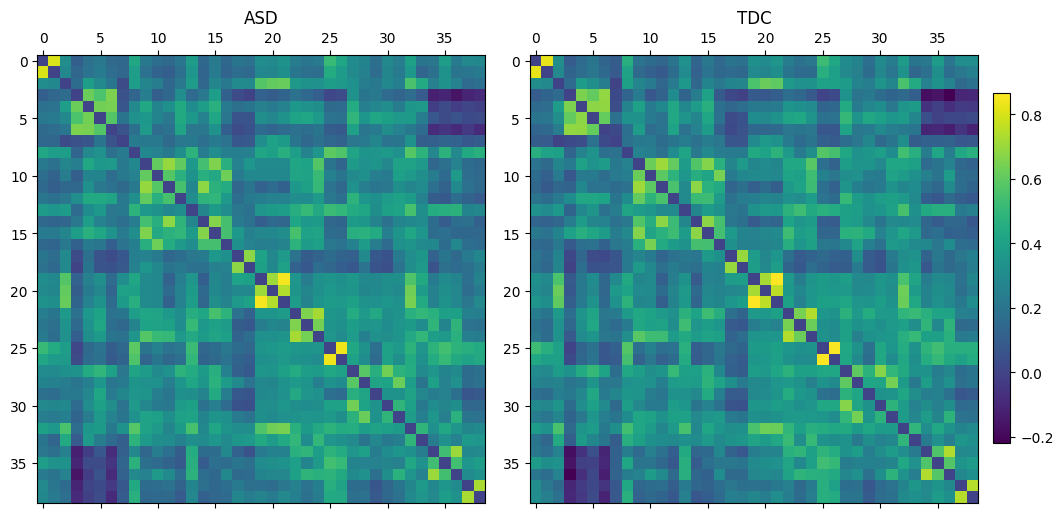

In [100]:
visualize_mat(asd_cov, tdc_cov, title='Covariance Matrices')

In [54]:
def plot_connectome(cov_matrix, coords, title='connectome', edge_threshold="70%"):
    """
    Plot the connectome using the mean correlation matrix and coordinates.
    """
    # Plotting the connectome
    plotting.plot_connectome(
        cov_matrix,
        coords,
        title=title,
        edge_threshold=edge_threshold,  # Only plot edges above the 90th percentile
        colorbar=True,
        node_size=10,
    )
    plt.show()

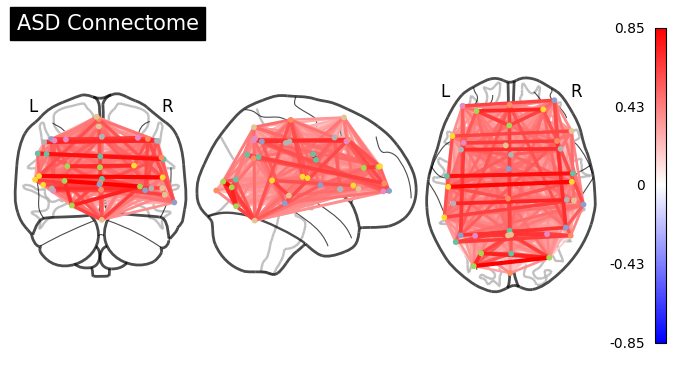

In [175]:
plot_connectome(asd_cov, msdl_coords, title='ASD Connectome', edge_threshold="0%")

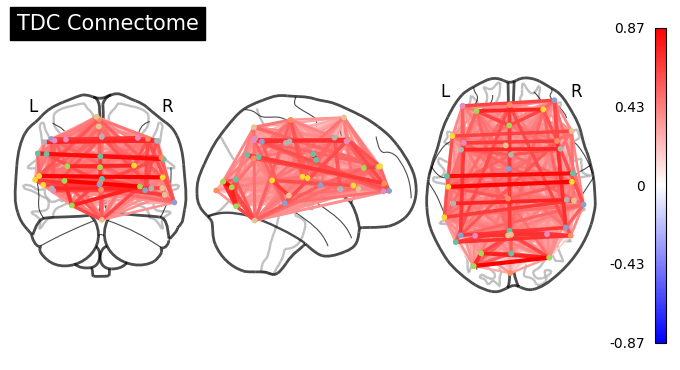

In [176]:
plot_connectome(tdc_cov, msdl_coords, title='TDC Connectome', edge_threshold="0%")

In [183]:
def graph_fc(fc_matrix):

    # Create NetworkX graph for visualization or further use
    G = nx.Graph()
    n = fc_matrix.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            if fc_matrix[i, j] != 0:
                G.add_edge(i, j, weight=fc_matrix[i, j])
    
    return G

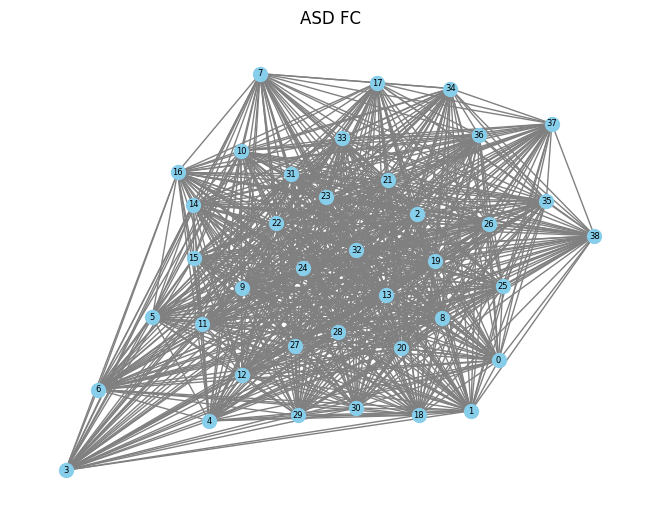

In [190]:
# Optional: visualize
G_asd_cov = graph_fc(asd_cov)
G_tdc_cov = graph_fc(tdc_cov)
nx.draw(G_asd_cov, with_labels=True, node_color='skyblue', node_size=100, font_size=6, edge_color='gray')
plt.title("ASD FC")
plt.show()

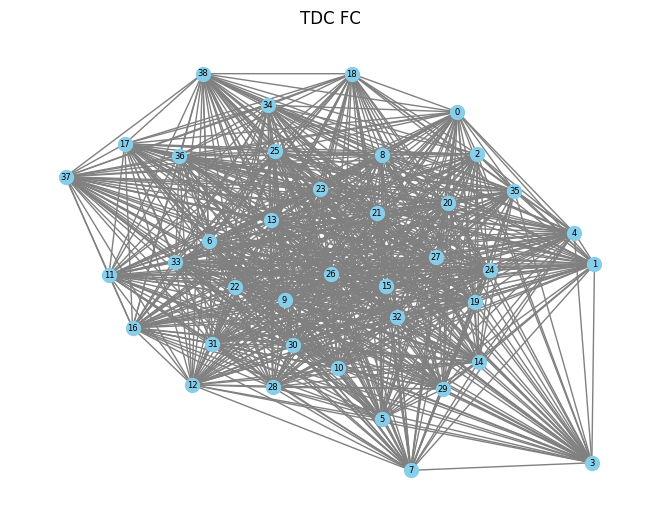

In [191]:
nx.draw(G_tdc_cov, with_labels=True, node_color='skyblue', node_size=100, font_size=6, edge_color='gray')
plt.title("TDC FC")
plt.show()

In [117]:
def mutual_information_continuous(x, y, bins=10):
    """
    Estimate mutual information between two continuous variables by discretizing them.

    Parameters:
    x (array-like): First continuous variable.
    y (array-like): Second continuous variable.
    bins (int): Number of bins to use for discretization.

    Returns:
    float: Estimated mutual information.
    """
    # Convert to pandas Series
    x = pd.Series(x)
    y = pd.Series(y)

    # Discretize the continuous values
    x_binned = pd.cut(x, bins=bins, labels=False)
    y_binned = pd.cut(y, bins=bins, labels=False)

    # Compute contingency table
    contingency_table = pd.crosstab(x_binned, y_binned)

    # Compute mutual information
    mi = mutual_info_score(None, None, contingency=contingency_table.values)

    return mi

def get_mutual_info(timeseries, bins=100):

    mutual_info_matrix = np.zeros((timeseries.shape[1], timeseries.shape[1]))

    # get mutual information
    for region in range(timeseries.shape[1]):
        for region2 in range(timeseries.shape[1]):
            if region != region2:
                mutual_info = mutual_information_continuous(timeseries[:, region], timeseries[:, region2], bins=bins)
                mutual_info_matrix[region, region2] = mutual_info
    
    return mutual_info_matrix


In [95]:
# try it for the first 150 timepoints
asd_mutual_info_150 = get_mutual_info(asd_concat[:150, :])
tdc_mutual_info_150 = get_mutual_info(tdc_concat[:150, :])

/var/folders/cf/4z622f6j29d4qx7rzj6l433m0000gp/T/ipykernel_74122/2901020615.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


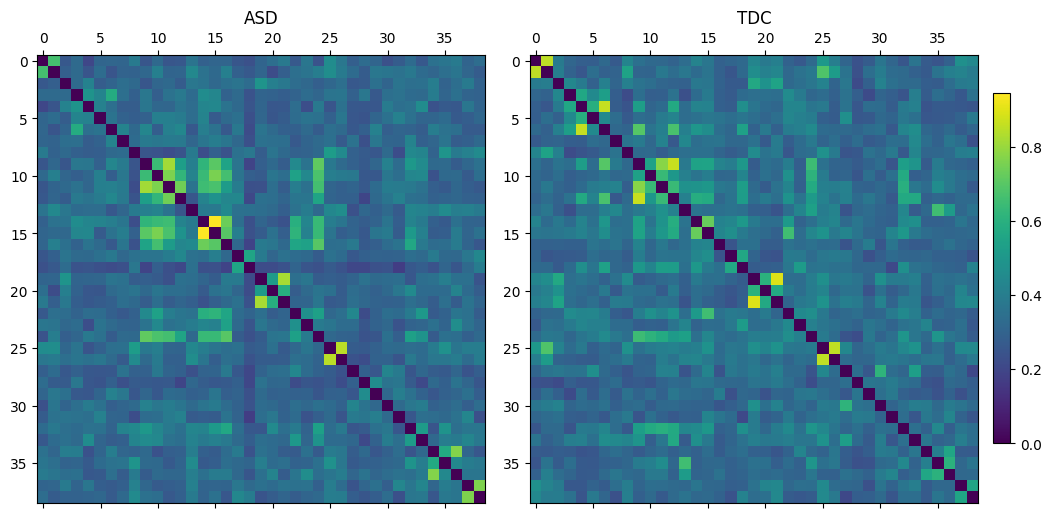

In [96]:
# visualize mutual information
visualize_mat(asd_mutual_info_150, tdc_mutual_info_150, title='Mutual Information Matrices (First 150 Timepoints)')

In [101]:
# first 1500 timepoints
asd_mutual_info_1500 = get_mutual_info(asd_concat[:1500, :])
tdc_mutual_info_1500 = get_mutual_info(tdc_concat[:1500, :])

/var/folders/cf/4z622f6j29d4qx7rzj6l433m0000gp/T/ipykernel_74122/2901020615.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


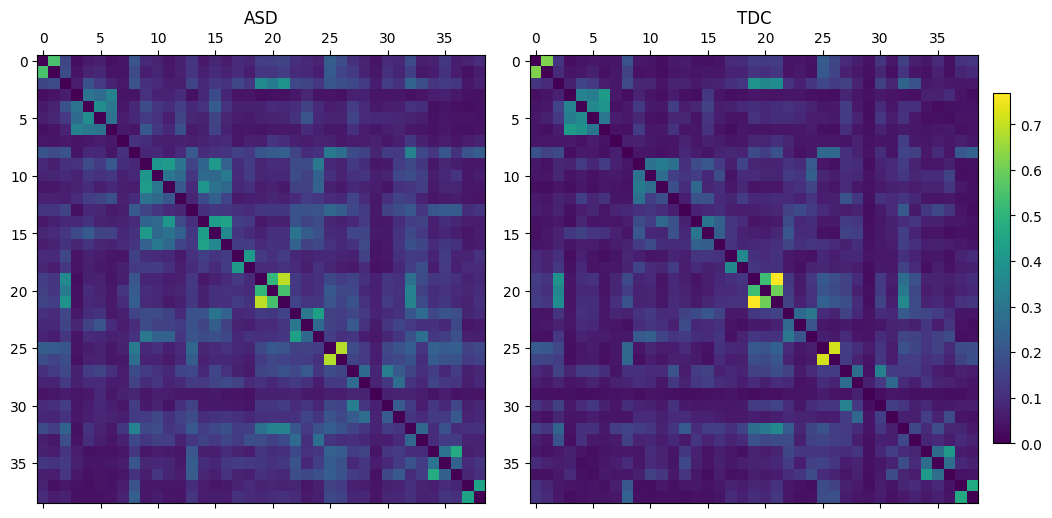

In [103]:
# visualize mutual information
visualize_mat(asd_mutual_info_1500, tdc_mutual_info_1500, title='Mutual Information Matrices (First 1500 Timepoints)')

In [104]:
# try all timepoints
asd_mutual_info = get_mutual_info(asd_concat, bins=10)
tdc_mutual_info = get_mutual_info(tdc_concat, bins=10)

/var/folders/cf/4z622f6j29d4qx7rzj6l433m0000gp/T/ipykernel_74122/2901020615.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


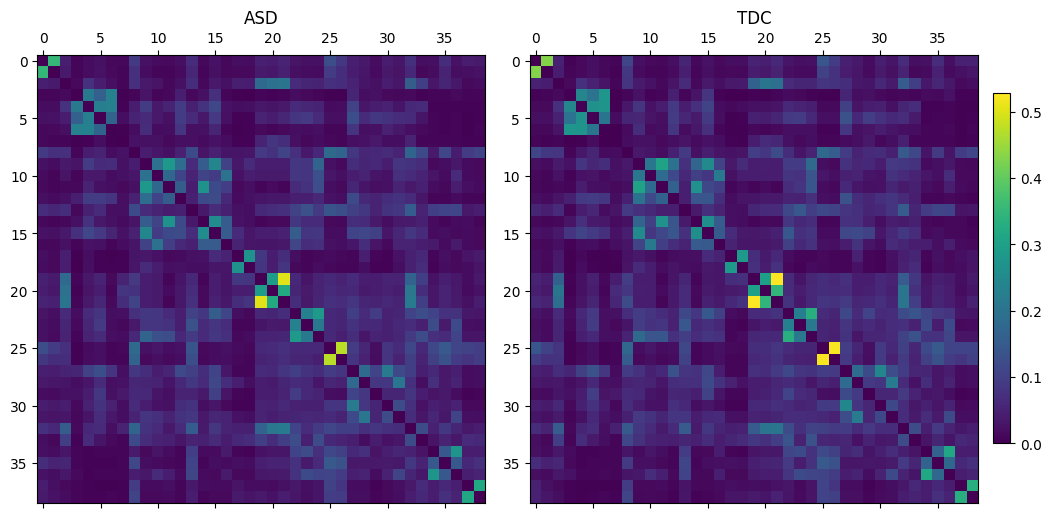

In [106]:
visualize_mat(asd_mutual_info, tdc_mutual_info, title='Mutual Information Matrices')

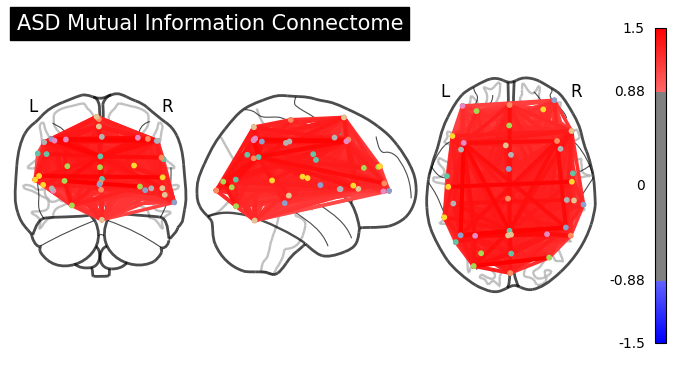

In [177]:
plot_connectome(asd_mutual_info, msdl_coords, title='ASD Mutual Information Connectome', edge_threshold="0%")

In [118]:
# try all timepoints, 1000 bins
asd_mutual_info = get_mutual_info(asd_concat, bins=1000)
tdc_mutual_info = get_mutual_info(tdc_concat, bins=1000)

In [120]:
# save matrices to csv
asd_mutual_info_df = pd.DataFrame(asd_mutual_info)
asd_mutual_info_df.to_csv(f'{base_dir}/code/functional_connectivity/abide/output/mutual_info/1000_bins/asd_mutual_info.csv', index=False)
tdc_mutual_info_df = pd.DataFrame(tdc_mutual_info)
tdc_mutual_info_df.to_csv(f'{base_dir}/code/functional_connectivity/abide/output/mutual_info/1000_bins/tdc_mutual_info.csv', index=False)

In [121]:
# load the saved matrices
asd_mutual_info = pd.read_csv(f'{base_dir}/code/functional_connectivity/abide/output/mutual_info/1000_bins/asd_mutual_info.csv').to_numpy()
tdc_mutual_info = pd.read_csv(f'{base_dir}/code/functional_connectivity/abide/output/mutual_info/1000_bins/tdc_mutual_info.csv').to_numpy()

/var/folders/cf/4z622f6j29d4qx7rzj6l433m0000gp/T/ipykernel_74122/2901020615.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


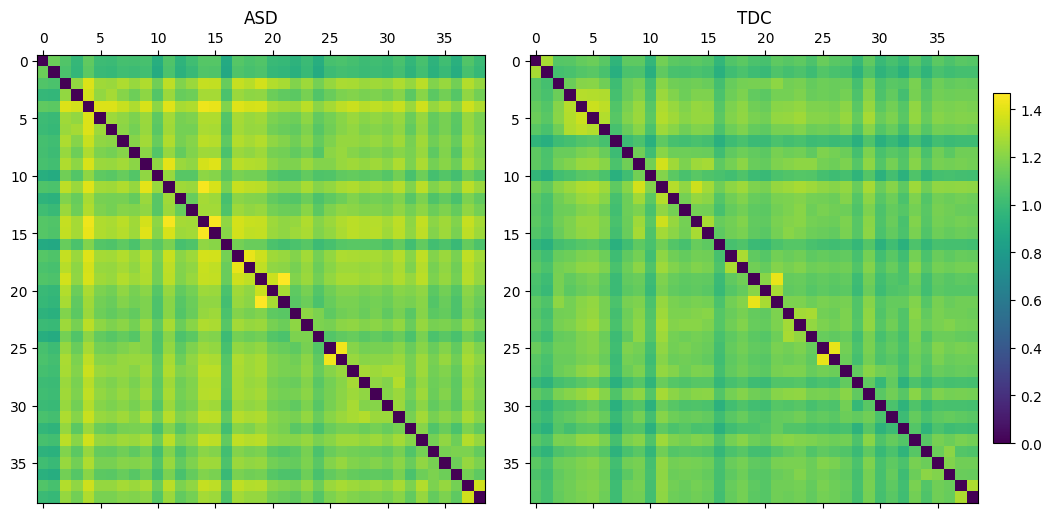

In [123]:
visualize_mat(asd_mutual_info, tdc_mutual_info, title='Mutual Information Matrices (1000 bins)')

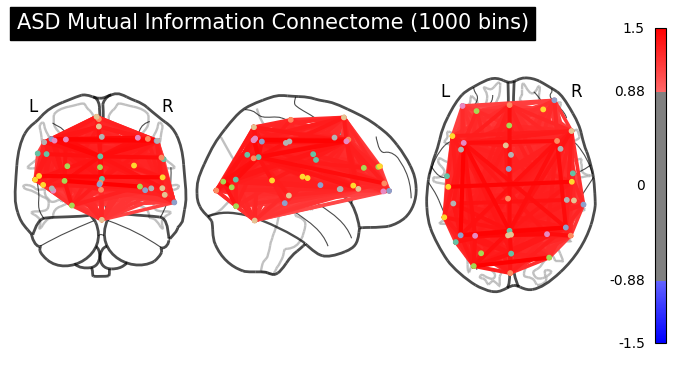

In [178]:
plot_connectome(asd_mutual_info, msdl_coords, title='ASD Mutual Information Connectome (1000 bins)', edge_threshold="0%")

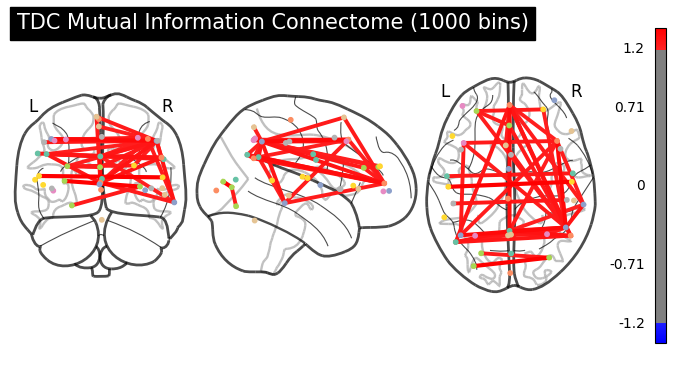

In [125]:
plot_connectome(tdc_mutual_info, msdl_coords, title='TDC Mutual Information Connectome (1000 bins)', edge_threshold="95%")

In [128]:
def chow_liu_tree(mi_matrix):
    
    # Construct the Chow-Liu tree from continuous data using mutual information.

    # We use the negative MI because scipy's minimum_spanning_tree computes *minimum* tree.
    mst = minimum_spanning_tree(-mi_matrix).toarray()

    # Make MST undirected and remove negative sign
    mst = -mst + (-mst).T

    # Create NetworkX graph for visualization or further use
    G = nx.Graph()
    n = mi_matrix.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            if mst[i, j] != 0:
                G.add_edge(i, j, weight=mi_matrix[i, j])
    
    return G, mst

In [131]:
G_asd, mst_asd = chow_liu_tree(asd_mutual_info)

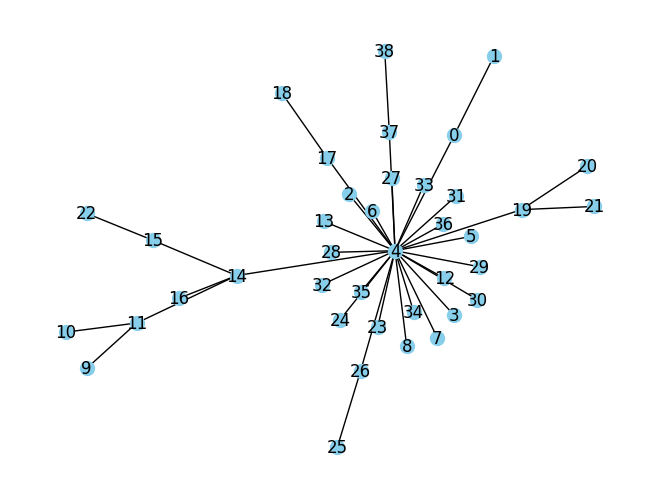

In [134]:
# Optional: visualize
nx.draw(G_asd, with_labels=True, node_color='skyblue', node_size=100)
plt.show()

In [137]:
def draw_chow_liu_tree(G, root=0):
    """
    Visualize the Chow-Liu tree using a spring layout (no pygraphviz).
    """
    tree = nx.bfs_tree(G, source=root)
    pos = nx.spring_layout(tree, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw(tree, pos, with_labels=True, arrows=True, node_color="lightblue", 
            edge_color="black", node_size=1500, font_size=12)
    
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in tree.edges()}
    nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels)

    plt.title("Chow-Liu Tree (Spring Layout)")
    plt.axis("off")
    plt.show()

In [162]:
def hierarchy_pos(G, root=None, width=1., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    """
    Hierarchical layout for directed trees. Assigns space to subtrees to avoid squishing.
    """
    def _count_descendants(G, node):
        children = list(G.successors(node))
        if not children:
            return 1
        return sum(_count_descendants(G, child) for child in children)

    def _hierarchy_pos(G, node, left, right, vert_loc, pos):
        center = (left + right) / 2
        pos[node] = (center, vert_loc)
        children = list(G.successors(node))
        if children:
            total = sum(_count_descendants(G, child) for child in children)
            dx = (right - left) / total
            next_left = left
            for child in children:
                size = _count_descendants(G, child)
                next_right = next_left + dx * size
                pos = _hierarchy_pos(G, child, next_left, next_right, vert_loc - vert_gap, pos)
                next_left = next_right
        return pos

    return _hierarchy_pos(G, root, 0, width, vert_loc, {})

def draw_hierarchical_tree(G, root=0, title = "Hierarchical Chow-Liu Tree"):
    """
    Draw Chow-Liu tree in a hierarchical top-down format.
    """
    # Ensure it's a directed tree rooted at `root`
    tree = nx.bfs_tree(G, source=root)

    pos = hierarchy_pos(tree, root)
    plt.figure(figsize=(10, 6))
    nx.draw(tree, pos, with_labels=True, node_color='lightcoral', node_size=140,
            arrows=True, font_size=6, edge_color='gray')

    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in tree.edges()}
    # nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size = 0)

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

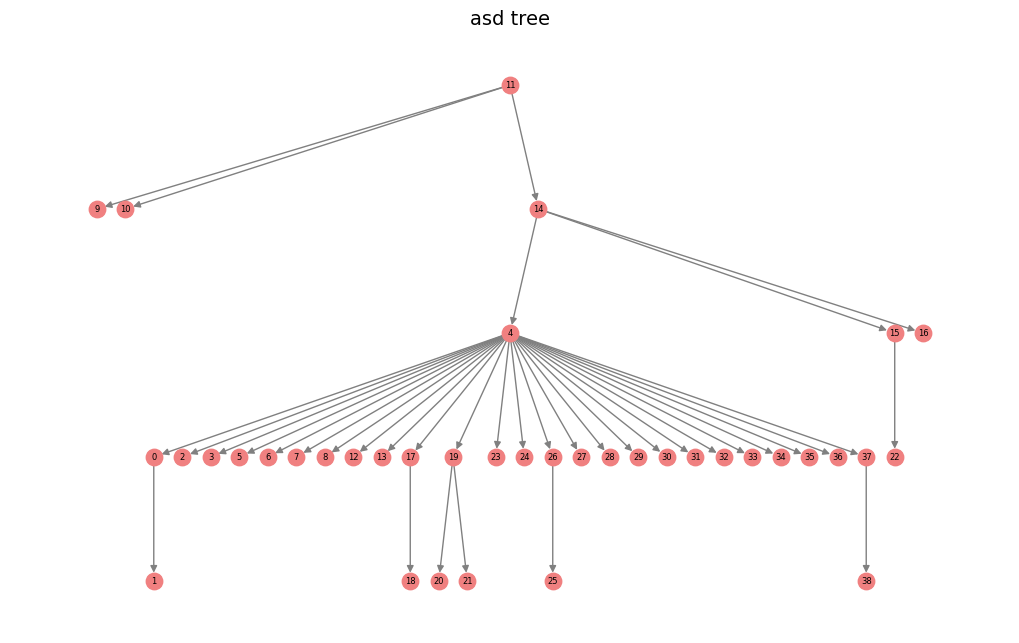

In [173]:
draw_hierarchical_tree(G_asd, root=11, title="asd tree")

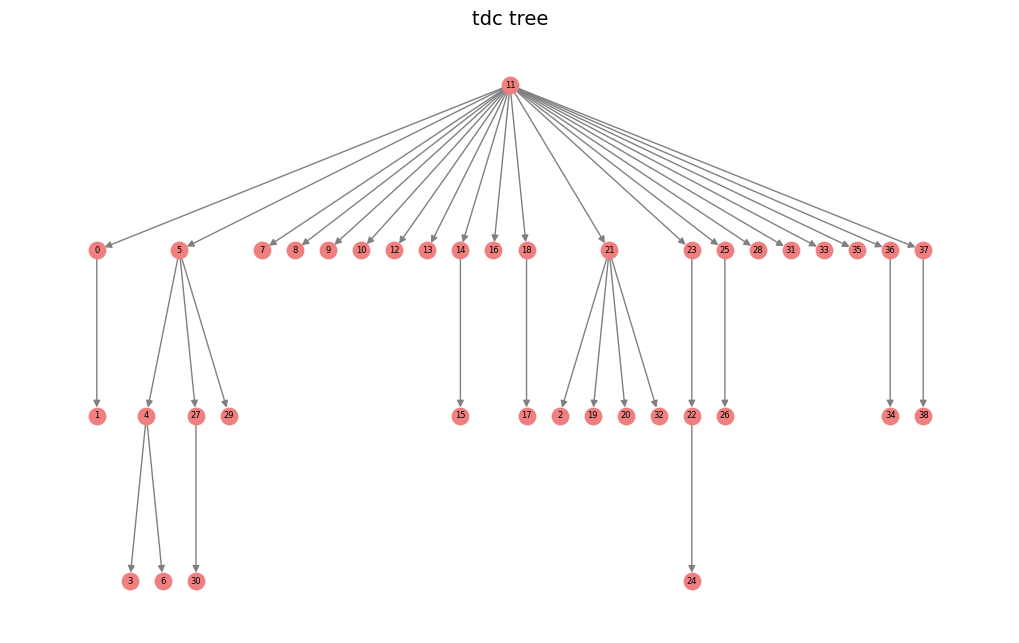

In [172]:
G_tdc, mst_tdc = chow_liu_tree(tdc_mutual_info)
draw_hierarchical_tree(G_tdc, root=11, title="tdc tree")

/var/folders/cf/4z622f6j29d4qx7rzj6l433m0000gp/T/ipykernel_74122/2901020615.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


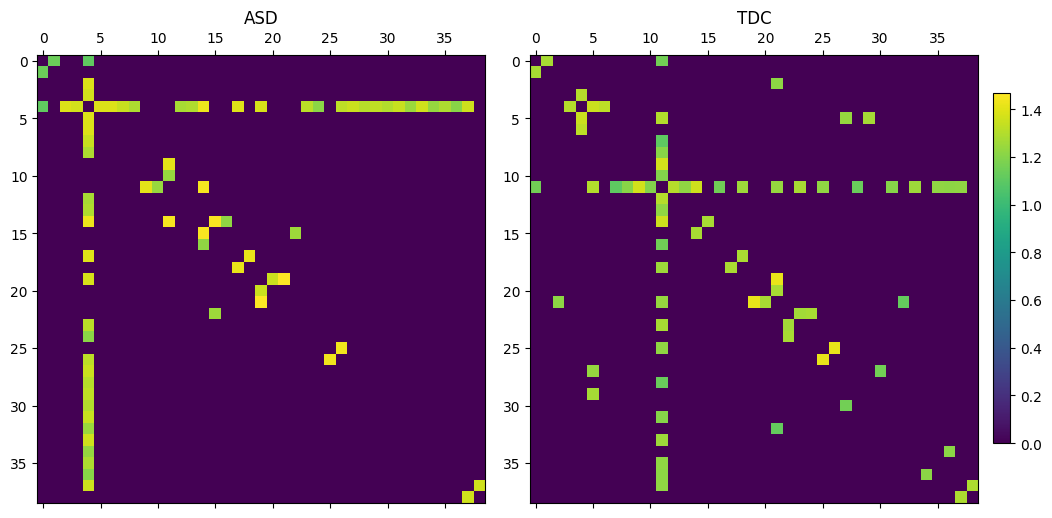

In [170]:
visualize_mat(mst_asd, mst_tdc, title='MST Matrices')

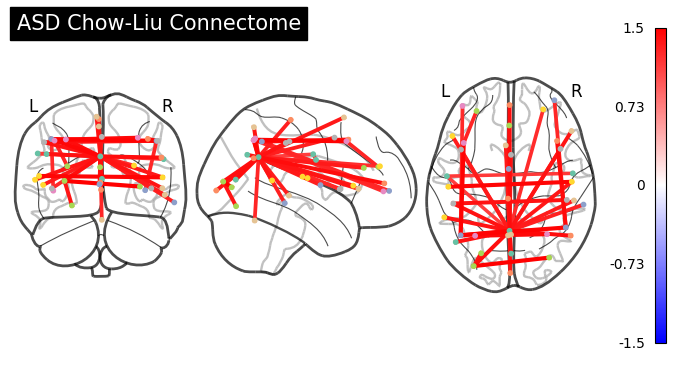

In [180]:
plot_connectome(mst_asd, msdl_coords, title='ASD Chow-Liu Connectome', edge_threshold="0%")

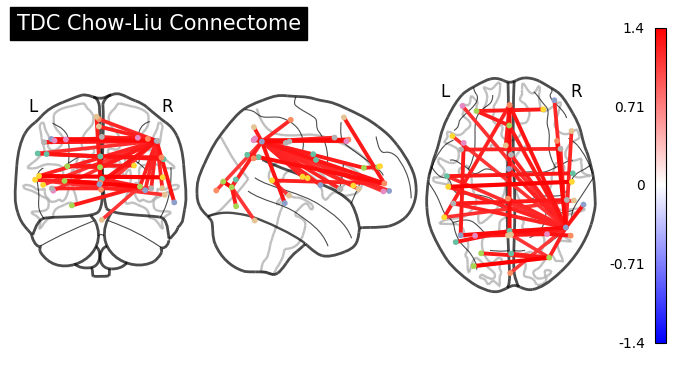

In [182]:
plot_connectome(mst_tdc, msdl_coords, title='TDC Chow-Liu Connectome', edge_threshold="0%")